In [ ]:
from dotenv import load_dotenv
from label_studio_sdk.client import LabelStudio
from glob import glob
from pathlib import Path
from sqlite3 import connect
from typing import Tuple
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn.linear_model

In [5]:
load_dotenv()

False

In [6]:
LABEL_STUDIO_URL = "https://labeler.e4e.ucsd.edu"
LABEL_STUDIO_API_KEY = os.environ["LABEL_STUDIO_API_KEY"]
LABEL_STUDIO_PROJECT_ID = 46

LABEL_STUDIO_URL, LABEL_STUDIO_API_KEY, LABEL_STUDIO_PROJECT_ID

KeyError: 'LABEL_STUDIO_API_KEY'

In [3]:
ipad_camera_intrinsics = np.array([[1604.2147, 0.0, 956.5816],
                                   [0.0, 1604.2147, 717.7617],
                                   [0.0, 0.0, 1.0]])
iphone_camera_intrinsics = np.array([[1375.0719, 0.0, 968.6433],
                                     [0.0, 1375.0719, 723.04926],
                                     [0.0, 0.0, 1.0]])

In [2]:
label_studio = LabelStudio(base_url=LABEL_STUDIO_URL, api_key=LABEL_STUDIO_API_KEY)

label_studio

NameError: name 'LABEL_STUDIO_URL' is not defined

In [32]:
rgbs = [Path(g).absolute().resolve() for g in glob("../data/2025.06.27.FishSense.SanDiego/**/**/FSM/rgb_*.jpg", recursive=True)]
timestamp_to_rgb_map = {int(f.stem[4:]):f for f in rgbs}

timestamp_to_rgb_map

{1751059596: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059596.jpg'),
 1751059200: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059200.jpg'),
 1751059821: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059821.jpg'),
 1751059518: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059518.jpg'),
 1751047797: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751047797.jpg'),
 1751048739: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processin

In [ ]:
def get_depth_map_and_confidence_map(timestamp: int, database_path: Path) -> Tuple[np.ndarray[float], np.ndarray[int]]:
    with connect(database_path) as connection:
        cursor = connection.cursor()

        query = """
        SELECT depth_bytes, depth_width, depth_height, confidence_bytes, confidence_width, confidence_height FROM photos
        WHERE utc_unix_timestamp = ?"""

        cursor.execute(query, (timestamp,))
        row = cursor.fetchone()

        depth_width = row[1]
        depth_height = row[2]
        depth_map = np.frombuffer(row[0], dtype=np.float32).reshape((depth_height, depth_width))

        confidence_width = row[4]
        confidence_height = row[5]
        confidence_map = np.frombuffer(row[3], dtype=np.int8).reshape((confidence_height, confidence_width))

    return depth_map, confidence_map

In [ ]:
def plane_ransac(depth_array):
    """
    Perform RANSAC to fit a plane to the depth data.
    Returns the coefficients of the plane equation Ax + By + C = z.
    Code written with Copilot help.
    """
    # Flatten the depth array and get valid points
    valid_points = np.argwhere(depth_array > 0)
    if len(valid_points) < 3:
        return 0, 0, 1  # Not enough points to fit a plane

    # Fit a plane using RANSAC
    from sklearn.linear_model import RANSACRegressor, LinearRegression

    X = valid_points[:, 1].reshape(-1, 1)  # x-coordinates
    Y = valid_points[:, 0].reshape(-1, 1)  # y-coordinates
    Z = depth_array[valid_points[:, 0], valid_points[:, 1]].reshape(-1, 1)  # z-coordinates

    model = RANSACRegressor(LinearRegression())
    model.fit(np.hstack((X, Y)), Z)

    return np.array(model.estimator_.coef_[0][0], model.estimator_.coef_[0][1], model.estimator_.intercept_[0])

In [ ]:
for task in label_studio.tasks.list(project=LABEL_STUDIO_PROJECT_ID):
    timestamp = int(Path(task.storage_filename).stem[4:])
    if timestamp not in timestamp_to_rgb_map:
        continue

    if not any(a["result"] for a in task.annotations):
        continue

    rgb_path = timestamp_to_rgb_map[timestamp]
    database_path = rgb_path.parent / "database.sqlite"

    rgb_image = cv2.imread(rgb_path)
    depth_map, confidence_map = get_depth_map_and_confidence_map(timestamp, database_path)

    snout = [r for a in task.annotations for r in a["result"] if any(k == "Snout" for k in r["value"]["keypointlabels"])][0]
    fork = [r for a in task.annotations for r in a["result"] if any(k == "Fork" for k in r["value"]["keypointlabels"])][0]

    snout = [snout["value"]["x"] / 100, snout["value"]["y"] / 100]
    fork = [fork["value"]["x"] / 100, fork["value"]["y"] / 100]

    annotations = np.array([snout, fork])
    rgb_height, rgb_width, _ = rgb_image.shape
    rgb_shape = np.array([rgb_width, rgb_height])
    rgb_annotations = annotations * rgb_shape

    depth_height, depth_width = depth_map.shape
    depth_map_shape = np.array([depth_width, depth_height])
    depth_annotations = annotations * depth_map_shape

    camera_intrinsics = ipad_camera_intrinsics if "iPad" in str(rgb_path) else iphone_camera_intrinsics

    depths = depth_map[depth_annotations[:, 1].astype(int), depth_annotations[:, 0].astype(int)]

    points3d = np.linalg.inv(camera_intrinsics) @ np.array([rgb_annotations[:, 0], rgb_annotations[:, 1], np.ones_like(rgb_annotations[:, 0])])
    for idx, depth_pixel in enumerate(depths):
        points3d[:, idx] *= depth_pixel

    fish_length = np.linalg.norm(points3d[:, 0] - points3d[:, 1])
    
    ransac_angle = np.arccos(np.dot(plane_ransac(depth_map), np.array([0, 0, 1]))/(np.linalg.norm(plane_ransac(depth_map))))

    break

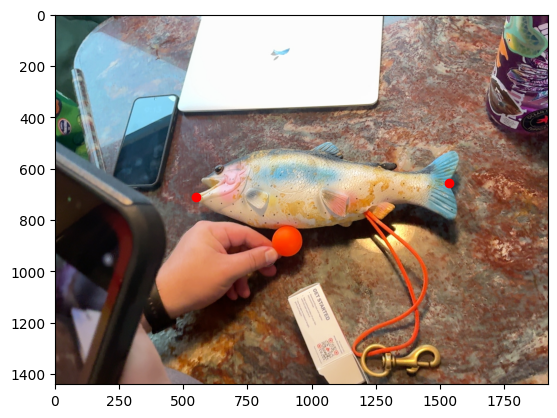

In [143]:
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.plot(rgb_annotations[:, 0], rgb_annotations[:, 1], 'ro')

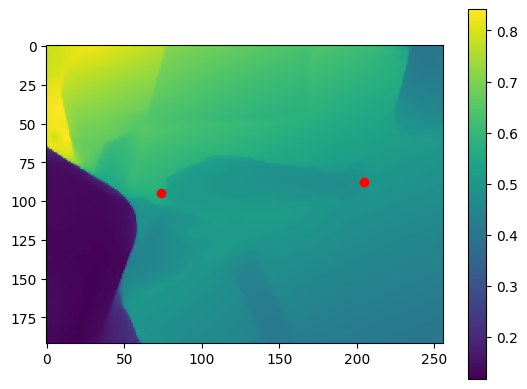

In [148]:
plt.imshow(depth_map)
plt.plot(depth_annotations[:, 0], depth_annotations[:, 1], 'ro')
plt.colorbar()

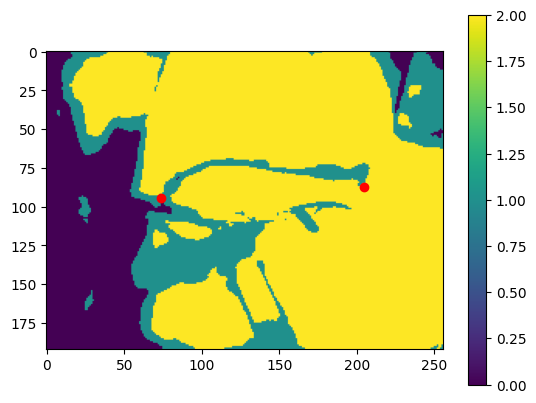

In [149]:
plt.imshow(confidence_map)
plt.plot(depth_annotations[:, 0], depth_annotations[:, 1], 'ro')
plt.colorbar()